In [1]:
import xarray as xr
import pandas as pd
import os
import noaa_csl_funcs as ncf
import pyproj
import numpy as np
import xesmf as xe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Base Data Handling

The "base" data is what I am calling NOAA CSL inventory data, downloaded from https://csl.noaa.gov/groups/csl7/measurements/2020covid-aqs/emissions/. These are the files downloaded and organized by "data_download.py". 

In [4]:
base_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/base' #where the data downloaded using data_download.py lives
bau_or_covid = 'COVID'
BCH = ncf.Base_CSL_Handler(base_path,bau_or_covid)
year = 2019
month = 1
sector = 'point_EGU'#'area_onroad_gasoline' 
day_type = 'satdy'

base_ds = BCH.load_fullday_nc(sector,year,month,day_type)
#base_ds

In [ ]:
#Check that each day has only two nc files
year_ints = [2019,2020,2021]
sectors = ncf.listdir_visible(base_path)
for sector in sectors:
    sector_path = os.path.join(base_path,sector)
    for year in year_ints:
        year_str = BCH.yr_to_yrstr(sector,year)
        year_path = os.path.join(sector_path,year_str)
        for month in ['Month01','Month02','Month03','Month04','Month05','Month06','Month07','Month08','Month09','Month10','Month11','Month12']:
            month_path = os.path.join(year_path,month)
            for day_type in ncf.listdir_visible(month_path):
                if day_type not in ['satdy','sundy','weekdy']:
                    print(month_path,day_type)
                    continue
                day_path = os.path.join(month_path,day_type)
                files_list = os.listdir(day_path)
                num_files = len(files_list)
                if num_files != 2:
                    print(day_path)    
           

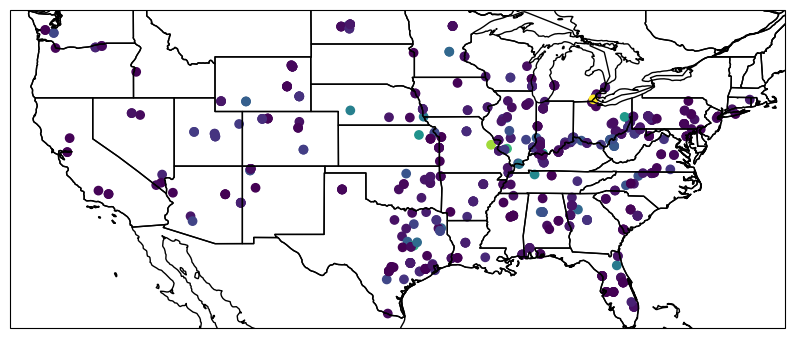

In [5]:
# Can use this if you are looking at a "point" dataset

df = base_ds['CO2'][1].to_dataframe()
sub_df = df.loc[df['CO2']>100]

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.scatter(sub_df['XLONG'],sub_df['XLAT'],c=sub_df['CO2'])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

# Regridding

Our goal is to go from the "base" noaa csl data, which is projected in Lambert Conformal Coordinates, to a lat/long (WGS) coordinate projection. The base data also has some inconsistencies, so we also standardize thinks like dimensions and attributes in the datasets. Part of the regridding process is a bit of unit conversion (to go from "absolute" units per gridcell to "flux" per m2). 

Lots of useful information was found here:       
https://medium.com/pangeo/changing-the-way-you-look-at-earth-data-with-xesmf-ee55d0b380e5          
https://fabienmaussion.info/2018/01/06/wrf-projection/     



In [6]:
#Define the day of data we want to regrid, and load it 
bau_or_covid = 'COVID'
full_sector = 'area_onroad_gasoline'
year = 2019
month = 1
day_type = 'weekdy'
BCH = ncf.Base_CSL_Handler(base_path,bau_or_covid)
base_ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})

In [8]:
#Need to convert from "absolute" units per gridcell to "flux" units in per m^2
unit_converter = ncf.CSL_Unit_Converter() #setup the unit converter
ds_flx = unit_converter.absolute_to_flux(base_ds) #convert absolute to flux
print('units = ',ds_flx['CO2'].attrs['units'])

units =  metric_Ton hr^-1 meters^-2


In [9]:
#Main regridding code
weights_path = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights' #define the weights path

inputs = ncf.RegridInputs #Define the inputs
inputs.weights_path = weights_path #Change any inputs from the default here
#change the weights file if you want a specific weights file
inputs.weights_file = '/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/saved_weights/lcc_to_latlon_onroad_gasoline_2019_1_weekdy.nc'

cr = ncf.CSL_Regridder(inputs) #create the regridder class
regridded_ds = cr.regrid_ds(ds_flx)

Creating regridder
Regridding


In [10]:
# You can save the regridder's weights to a file so you don't have to create it every time
cr.save_regrid_weights(cr.regridder)

## Sanity Checking

To check our sanity, we want to compare the data before we regridded it to after we regridded it. To do this, we need to convert to a common unit, as the before data was in LCC per gridcell, and the regridded data is in lat/lon in flux. 

In [11]:
#Load the original dataset
og_ds = BCH.load_fullday_nc(full_sector,year,month,day_type)#,chunks={'Time':1})
#og_ds

### Grid Cell area
We need to know the area of each grid cell in the regridded dataset so we can convert back to absolute units (per grid cell). I didn't find a good python solution for getting the grid cell area, but the "CDO" package is useful for this, but needs nc files. 

In [12]:
#Save a subset o fthe regridded data as a netcdf 
sub_regridded_ds = regridded_ds['CO2'][1,:,:]
sub_regridded_ds.to_netcdf('./test/grid_out.nc')

Open a terminal in this subdir and run 
> cdo gridarea ./test/grid_out.nc ./test/grid_out_area.nc

In [13]:
#Now we should have a file with the grid area
grid_area = xr.open_dataset('./test/grid_out_area.nc')
#grid_area

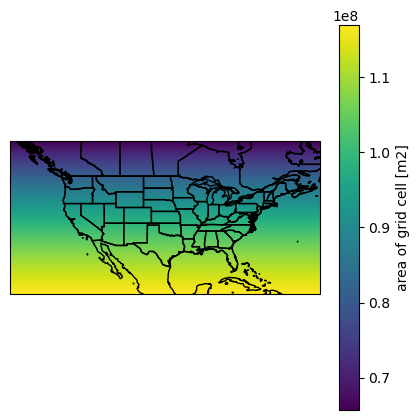

In [14]:
#Plot the grid cell area on a map -- should be less to the north and more to the south due to earth's shape
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection = proj)
grid_area['cell_area'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

Now we can do the actual sanity check by looking at the sum of all values in the grid for a specific species both before and after regridding and compare their difference. Colin Harkins notes less than 4% is good

In [15]:
def sanity_check(og_ds,regridded_ds,regridded_ds_cellarea,species):
    '''A sanity check using daily sums of a single species to see if the total before and after regridding is close
    
    Args:
    og_ds (xr.Dataset) : the original dataset loaded from "base" noaa_csl data in LCC 
    regridded_ds (xr.Dataset) : the regridded dataset in WGS
    regridded_ds_cellarea (xr.Dataset) : a dataset with a cell_area data var giving the cell area in m2 for each cell in the regridded ds. from a loaded nc created by cdo gridarea 
    species (str) : the species to check
    
    Returns:
    perc_diff (float) : the difference (in percent) between the daily sum of all grid cells in the original versus the regridded dataset
    '''
    
    original_sum = float(og_ds[species].sum().values)
    regrid_daysum = regridded_ds[species].sum(dim='utc_hour')
    regrid_daysum_absolute = regrid_daysum * regridded_ds_cellarea['cell_area']
    regrid_sum = float(regrid_daysum_absolute.sum().values)
    perc_diff = abs(regrid_sum-original_sum)/((regrid_sum+original_sum)/2)*100
    print(f'{round(perc_diff,3)}% difference between base and regridded sums for {species}')
    return perc_diff

In [16]:
regridded_ds_cellarea = xr.open_dataset('./test/grid_out_area.nc')
perc_diff = sanity_check(og_ds,regridded_ds,regridded_ds_cellarea,'CO2')

0.265% difference between base and regridded sums for CO2


### Map

Perhaps the best sanity check is to look on a map

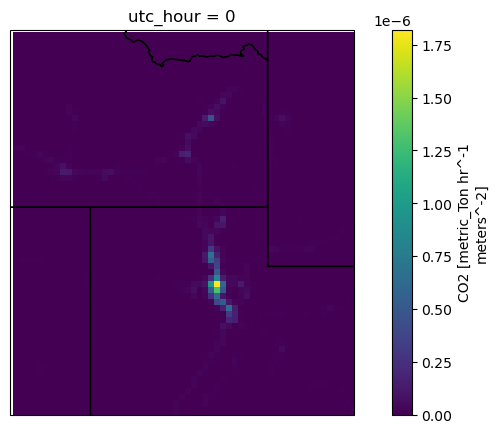

In [17]:
utc_hour = 0
species = 'CO2'

map_extent={'lon_low':-115.4,
            'lon_high':-109.6,
            'lat_low':38.5,
            'lat_high':45.0}

cropped_ds = regridded_ds.sel(lat=slice(map_extent['lat_low'],map_extent['lat_high']), lon=slice(map_extent['lon_low'],map_extent['lon_high']))

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
cropped_ds.sel({'utc_hour':utc_hour})['CO2'].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

## Unit conversion

Ongoing work about unit conversion

In [ ]:
class CSLSpeciesDetails:
    def __init__(self,csv_fullpath):
        self.csv_fullpath = csv_fullpath
        self.df = self.load_details_csv()

    def load_details_csv(self,csv_fullpath = None):
        if csv_fullpath is None:
            csv_fullpath = self.csv_fullpath
        
        species_details_df = pd.read_csv(csv_fullpath,header = 17)
        return species_details_df
    
    def make_mw_dict(self,saprc_version = 'either'):
        mw_dict = {}
        if saprc_version == 'either':
            for _,row in self.df.iterrows():
                species = row['NC_name']
                mw_dict[species] = {}
                if row['Known_MW'] == row['Known_MW']: #known mw is not a nan, so use this first
                    mw_dict[species]['mw(g/mol)']=row['Known_MW']
                    mw_dict[species]['mw_source'] ='Known_MW'
                elif row['SAPRC99_MW'] == row['SAPRC99_MW']: #use saprc99 first
                    mw_dict[species]['mw(g/mol)'] = row['SAPRC99_MW']
                    mw_dict[species]['mw_source'] = 'SAPRC99_MW'        
                elif row['SAPRC22_MW'] == row['SAPRC22_MW']: #use saprc22 next
                    mw_dict[species]['mw(g/mol)'] = row['SAPRC22_MW']
                    mw_dict[species]['mw_source'] = 'SAPRC22_MW'      
                else:
                    mw_dict[species]['mw(g/mol)'] = np.nan
                    mw_dict[species]['mw_source'] = np.nan   
        else:
            raise ValueError('Havent made anything other that "either"')  #could do SAPRC22 only, 99 only, mixed etc TODO
        return mw_dict
    
csd = CSLSpeciesDetails('/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/NOAA_CSL_species.csv')
csl_mw_dict = csd.make_mw_dict()


In [ ]:
regridded_ds[list(regridded_ds.data_vars.keys())[0]].attrs['units']

In [ ]:
for species in list(regridded_ds.data_vars.keys()):
    species_units_list = unit_converter.unit_finder(regridded_ds[species])
    if ('metric_Ton' in species_units_list) or ('metric_Ton(NO2equiv)' in species_units_list):
        print(species)

In [ ]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
#regridded_ds['CO2'][10,:,:].plot.pcolormesh('lon','lat',ax = ax,alpha=0.9,cmap='viridis')
regridded_ds_grams[0,:,:].plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
plt.show()

# Post Regrid Data Handling

In [ ]:

    #     self.sectors = self.get_sectors()

    # def get_sectors(self):
    #     '''Lists the sectors in the base data storage path'''

    #     sector_list = listdir_visible(self.base_path)
    #     sectors = {'area':[],'point':[]}
    #     for sector in sector_list:
    #         if 'area' in sector:
    #             sectors['area'].append(sector)
    #         elif 'point' in sector:
    #             sectors['point'].append(sector)
    #         else:
    #             raise ValueError(f"Unexpected sector type {sector}, not point or area.")
    #     return sectors

    # def get_sector_subset_list(self,sector_subset):
    #     if sector_subset == 'all':
    #         sector_subset_list = []
    #         for k,v in self.sectors.items():
    #             sector_subset_list.extend(v)
    #         return sector_subset_list
    #     elif type(sector_subset)==str:
    #         return self.sectors[sector_subset]
    #     else:
    #         return sector_subset

    # def get_days_in_range(self,dt1,dt2,day_types,sector_subset = 'all',add_base_path=True):
    #     '''Gets all filepaths to the day_type level that are within a datetime range
        
    #     Args:
    #     dt1 (datetime.date) : a date, datetime, etc to start the range (will only use year and month)
    #     dt2 (datetime.date) : a date, datetime, etc to end the range (will only use year and month)
    #     sectors (list) : list of sectors to include in the list
    #     day_types (list) : list of day types to include in the list
    #     add_base_path (bool, optional) : if true (default) it will add the base path to each element

    #     Returns:
    #     days_in_range (list) : list of paths to files that are within the date range and sector, day_types, etc. 
    #     '''

    #     dates_list = pd.date_range(dt1,dt2,freq = 'MS') #get a list of all the months between the dts
    #     sector_subset_list = self.get_sector_subset_list(sector_subset)
    #     days_in_range = []
    #     for date in dates_list:
    #         for sector in sector_subset_list:
    #             for day_type in day_types:
    #                 day_path = f'{sector}/{self.yr_to_yrstr(sector,date.year)}/{month_int_to_str(date.month)}/{day_type}'
    #                 if add_base_path:
    #                     days_in_range.append(os.path.join(self.base_path,day_path))
    #                 else:
    #                     days_in_range.append(day_path)
    #     return days_in_range